In [128]:
import pandas as pd
import numpy as np
from itertools import cycle
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as st

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
# from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

from xgboost import plot_importance
import os

In [11]:
def hyperopt_model(model, params, X, y, evals=30):
    def hyperopt_score(params):
        clf = model(**params)
        return -cross_val_score(clf, X, y, scoring='neg_root_mean_squared_error', cv=5).mean()

    best = fmin(fn=hyperopt_score, space=params, algo=tpe.suggest, max_evals=evals)
    return model(**space_eval(params, best))

In [133]:
'''
CLARKE ERROR GRID ANALYSIS      ClarkeErrorGrid.py
Need Matplotlib Pyplot
The Clarke Error Grid shows the differences between a blood glucose predictive measurement and a reference measurement,
and it shows the clinical significance of the differences between these values.
The x-axis corresponds to the reference value and the y-axis corresponds to the prediction.
The diagonal line shows the prediction value is the exact same as the reference value.
This grid is split into five zones. Zone A is defined as clinical accuracy while
zones C, D, and E are considered clinical error.
Zone A: Clinically Accurate
    This zone holds the values that differ from the reference values no more than 20 percent
    or the values in the hypoglycemic range (<70 mg/dl).
    According to the literature, values in zone A are considered clinically accurate.
    These values would lead to clinically correct treatment decisions.
Zone B: Clinically Acceptable
    This zone holds values that differe more than 20 percent but would lead to
    benign or no treatment based on assumptions.
Zone C: Overcorrecting
    This zone leads to overcorrecting acceptable BG levels.
Zone D: Failure to Detect
    This zone leads to failure to detect and treat errors in BG levels.
    The actual BG levels are outside of the acceptable levels while the predictions
    lie within the acceptable range
Zone E: Erroneous treatment
    This zone leads to erroneous treatment because prediction values are opposite to
    actual BG levels, and treatment would be opposite to what is recommended.
SYNTAX:
        plot, zone = clarke_error_grid(ref_values, pred_values, title_string)
INPUT:
        ref_values          List of n reference values.
        pred_values         List of n prediciton values.
        title_string        String of the title.
OUTPUT:
        plot                The Clarke Error Grid Plot returned by the function.
                            Use this with plot.show()
        zone                List of values in each zone.
                            0=A, 1=B, 2=C, 3=D, 4=E
EXAMPLE:
        plot, zone = clarke_error_grid(ref_values, pred_values, "00897741 Linear Regression")
        plot.show()
References:
[1]     Clarke, WL. (2005). "The Original Clarke Error Grid Analysis (EGA)."
        Diabetes Technology and Therapeutics 7(5), pp. 776-779.
[2]     Maran, A. et al. (2002). "Continuous Subcutaneous Glucose Monitoring in Diabetic
        Patients" Diabetes Care, 25(2).
[3]     Kovatchev, B.P. et al. (2004). "Evaluating the Accuracy of Continuous Glucose-
        Monitoring Sensors" Diabetes Care, 27(8).
[4]     Guevara, E. and Gonzalez, F. J. (2008). Prediction of Glucose Concentration by
        Impedance Phase Measurements, in MEDICAL PHYSICS: Tenth Mexican
        Symposium on Medical Physics, Mexico City, Mexico, vol. 1032, pp.
        259261.
[5]     Guevara, E. and Gonzalez, F. J. (2010). Joint optical-electrical technique for
        noninvasive glucose monitoring, REVISTA MEXICANA DE FISICA, vol. 56,
        no. 5, pp. 430434.
Made by:
Trevor Tsue
7/18/17
Based on the Matlab Clarke Error Grid Analysis File Version 1.2 by:
Edgar Guevara Codina
codina@REMOVETHIScactus.iico.uaslp.mx
March 29 2013
'''



import matplotlib.pyplot as plt


#This function takes in the reference values and the prediction values as lists and returns a list with each index corresponding to the total number
#of points within that zone (0=A, 1=B, 2=C, 3=D, 4=E) and the plot
def clarke_error_grid(ref_values, pred_values, title_string):

    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    plt.title(title_string + " Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    #plt.plot([175/3, 320], [70, 400], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    # plt.plot([70, 70], [0, 175/3], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 400],[175/3, 320],'-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    return zone, np.round((np.array(zone) * 100) / len(ref_values), 2)

In [106]:
# space_svm = {
#       'C': hp.choice('C', np.arange(0.5,20, 0.5)),
#       'kernel': hp.choice('kernel',['rbf']),
#       'degree':hp.choice('degree',[2,3,4])      }

xgboost_space={
            'max_depth': hp.choice('x_max_depth',[2,3,4,5,6]),
            'min_child_weight':hp.choice('x_min_child_weight',np.round(np.arange(0.0,0.2,0.01),5)),
            'learning_rate':hp.choice('x_learning_rate',np.round(np.arange(0.005,0.3,0.01),5)),
            'subsample':hp.choice('x_subsample',np.round(np.arange(0.1,1.0,0.05),5)),
            'colsample_bylevel':hp.choice('x_colsample_bylevel',np.round(np.arange(0.1,1.0,0.05),5)),
            'colsample_bytree':hp.choice('x_colsample_bytree',np.round(np.arange(0.1,1.0,0.05),5)),
            'n_estimators':hp.choice('x_n_estimators',np.arange(100, 300, 50))
}

space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    'n_estimators': hp.choice('n_estimators', range(100,1000, 100)),
}

In [76]:
def model_boundaries(model, X_train, y_train, scoring, cv=5):
    ''' вычисление дов. ин-ла по n фолдам кросс-валидации'''
    # вычисляем score на кросс валидации
    val_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
    # доверительный интервал
    conf_interval = st.t.interval(0.95, len(val_scores)-1, loc=val_scores.mean(), scale=val_scores.std())
    return conf_interval

*Пайплайн построения и оценки моделей*
* Считывание датасета, выделение таргета и нужных колонок
* Отбор топ 6 по корреляции
* Разделение на обучение и тест
* Подбор гиперпараметров по кросс валидации, их доверительные интервалы
* Обучение, тестирование, отображение R2, RMSE, сетку ошибок кларка, важность фичей

In [187]:
def build_asses_model(file, model, model_space, model_nm='xgb', evals=50):
    print(file.upper())
    df = pd.read_csv(f'datasets\\{file}')
    df = df.dropna(subset=df.iloc[:, 2:42].columns)
    y = df['Уровень глюкозы, ммоль/л']
    print(f'Target STD: {y.std():.3f}')
    # отбор признаков
    df = df.iloc[:, 2:42]
    first  = df.iloc[:, 0] != -1
    for column in df.columns:
        first |= df[column] != -1
    df = df[first]
    selector = SelectKBest(f_regression, k=4)
    X_corr = selector.fit_transform(df, y)
    feature_names = list(df.columns[selector.get_support()])
    sns.heatmap(df.loc[:, feature_names].corrwith(y).to_numpy().reshape(-1, 1), annot=True, yticklabels=feature_names)

    # обучение и тестирование
    X_train, X_test, y_train, y_test = train_test_split(X_corr, y, test_size=0.25, random_state=0)
    print(f'Размер обучающей выборки: {len(X_train)}\nРазмер тестовой выборки: {len(X_test)}')
    model = hyperopt_model(model, model_space, X_train, y_train, evals=evals)
    lower, upper = model_boundaries(model, X_train, y_train, scoring="neg_root_mean_squared_error")
    print(f'95% доверительный интервал модели для RMSE по кросс валидации: ({lower:.3f}, {upper:.3f})')
    model.fit(X_train, y_train)
    if 'XGB' in str(model):
        plt.figure(figsize=(12, 8))
        model.get_booster().feature_names = feature_names
        plot_importance(model.get_booster())
    elif 'Random' in str(model):
        fig, ax = plt.subplots()
        importances = model.feature_importances_
        std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
        forest_importances = pd.Series(importances, index=feature_names)
        forest_importances.plot.bar(yerr=std, ax=ax)
        ax.set_title("Feature importances using MDI")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()
    preds = model.predict(X_test)
    print(f'R2 test: {r2_score(y_test, preds):.3f}, RMSE test: {mean_squared_error(y_test, preds)**0.5:.3f}')
    plt.figure(figsize=(12, 8))
    abs_zone, rel_zone = clarke_error_grid(y_test.to_numpy()*18.02, preds*18.02, 'Error GRid')
    pd.DataFrame.from_dict({'A':[f'{abs_zone[0]}({rel_zone[0]}%)'], 'B':[f'{abs_zone[1]}({rel_zone[1]}%)'], 
                  'C':[f'{abs_zone[2]}({rel_zone[2]}%)'], 'D':[f'{abs_zone[3]}({rel_zone[3]}%)'],
                           'E':[f'{abs_zone[4]}({rel_zone[4]}%)']}).to_excel(f'results/{file[:-4]}_{model_nm}.xlsx', index=False)
    print(f'Clarke Error Grid: A - {abs_zone[0]}({rel_zone[0]}%), B - {abs_zone[1]}({rel_zone[1]}%), C - {abs_zone[2]}({rel_zone[2]}%), D - {abs_zone[3]}({rel_zone[3]}%), E - {abs_zone[4]}({rel_zone[4]}%)', end='\n\n')

## Выборка женщин

WOMEN.CSV
Target STD: 3.374
Размер обучающей выборки: 1413
Размер тестовой выборки: 471
100%|██████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.41trial/s, best loss: 3.05914858877109]
95% доверительный интервал модели для RMSE по кросс валидации: (2.749, 3.369)
R2 test: 0.172, RMSE test: 3.056
Clarke Error Grid: A - 173(36.73%), B - 259(54.99%), C - 0(0.0%), D - 38(8.07%), E - 1(0.21%)



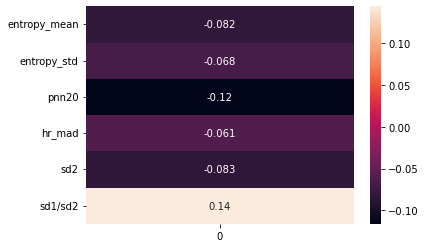

<Figure size 864x576 with 0 Axes>

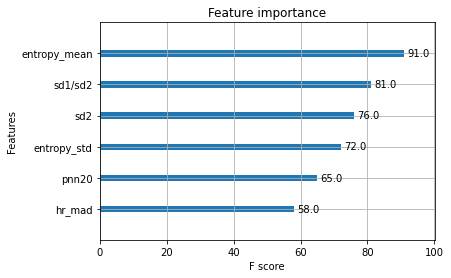

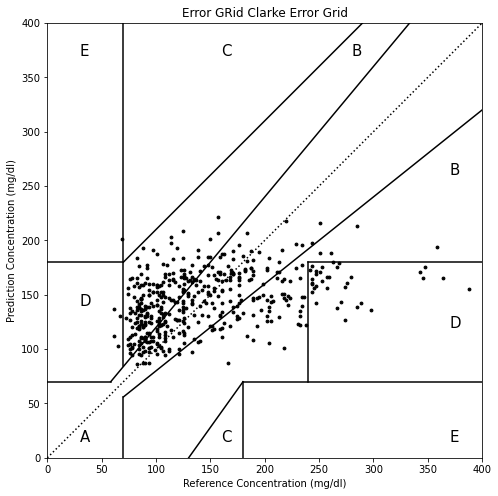

In [154]:
build_asses_model('women.csv', XGBRegressor, xgboost_space)

WOMEN.CSV
Target STD: 3.374
Размер обучающей выборки: 1413
Размер тестовой выборки: 471
100%|████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.46s/trial, best loss: 3.0649437430341298]
95% доверительный интервал модели для RMSE по кросс валидации: (2.809, 3.325)
R2 test: 0.195, RMSE test: 3.014
Clarke Error Grid: A - 164(34.82%), B - 269(57.11%), C - 0(0.0%), D - 37(7.86%), E - 1(0.21%)



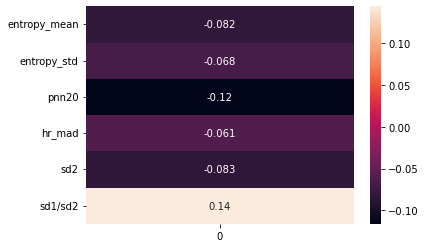

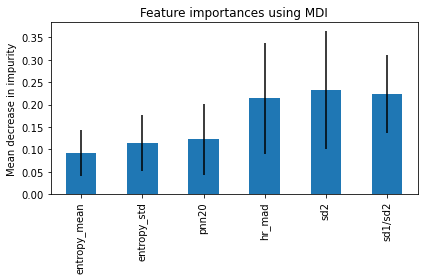

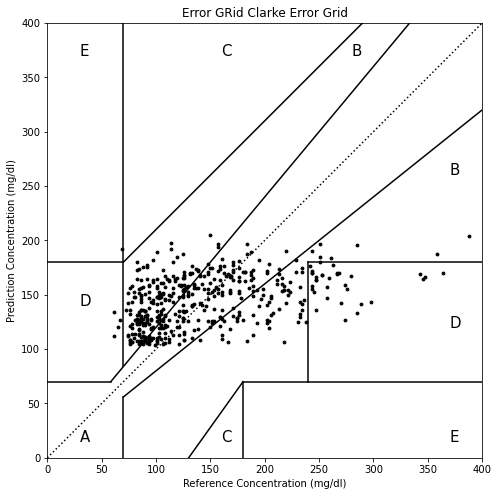

In [156]:
build_asses_model('women.csv', RandomForestRegressor, space4rf, model_nm='rf', evals=20)

## Выборка мужчин

MEN.CSV
Target STD: 3.329
Размер обучающей выборки: 684
Размер тестовой выборки: 229
100%|████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.71trial/s, best loss: 3.2440604613612307]
95% доверительный интервал модели для RMSE по кросс валидации: (2.806, 3.682)
R2 test: 0.025, RMSE test: 3.127
Clarke Error Grid: A - 100(43.67%), B - 113(49.34%), C - 0(0.0%), D - 16(6.99%), E - 0(0.0%)



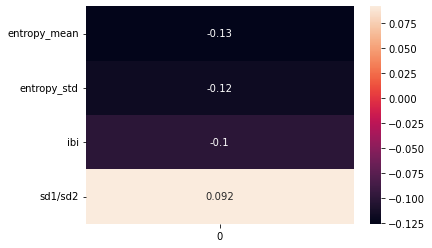

<Figure size 864x576 with 0 Axes>

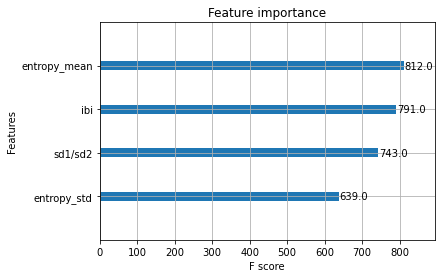

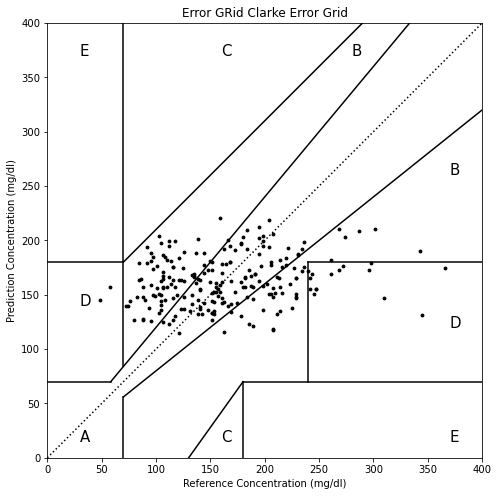

In [188]:
build_asses_model('men.csv', XGBRegressor, xgboost_space)

MEN.CSV
Target STD: 3.329
Размер обучающей выборки: 684
Размер тестовой выборки: 229
100%|█████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/trial, best loss: 3.272245022061038]
95% доверительный интервал модели для RMSE по кросс валидации: (2.849, 3.699)
R2 test: 0.062, RMSE test: 3.068
Clarke Error Grid: A - 94(41.05%), B - 119(51.97%), C - 0(0.0%), D - 16(6.99%), E - 0(0.0%)



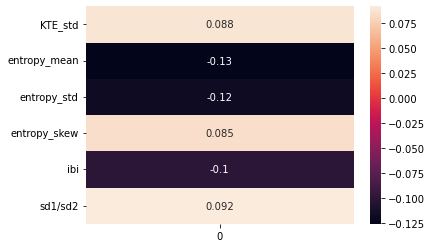

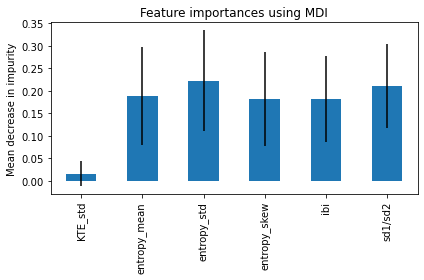

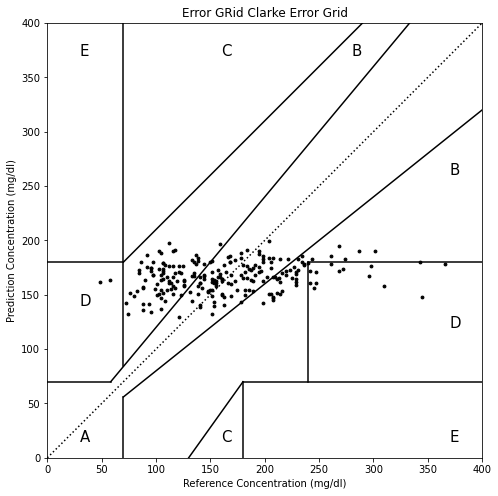

In [158]:
build_asses_model('men.csv', RandomForestRegressor, space4rf, model_nm='rf', evals=20)

## Выборка людей с диабетом

DIABETES.CSV
Target STD: 3.283
Размер обучающей выборки: 1506
Размер тестовой выборки: 502
100%|█████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.79trial/s, best loss: 3.233963922372696]
95% доверительный интервал модели для RMSE по кросс валидации: (2.869, 3.599)
R2 test: 0.015, RMSE test: 3.354
Clarke Error Grid: A - 223(44.42%), B - 211(42.03%), C - 2(0.4%), D - 66(13.15%), E - 0(0.0%)



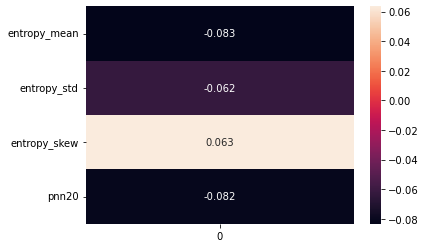

<Figure size 864x576 with 0 Axes>

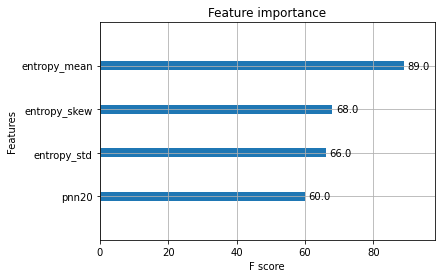

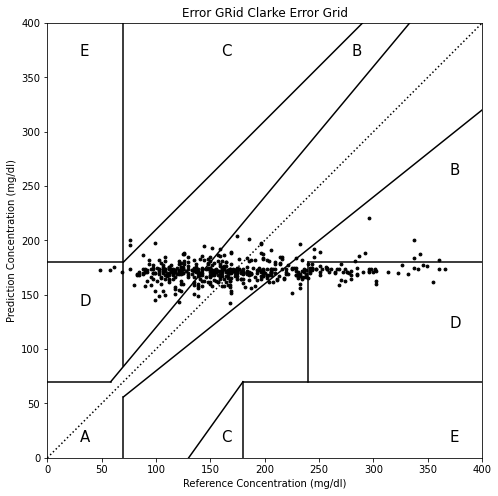

In [189]:
build_asses_model('diabetes.csv', XGBRegressor, xgboost_space)

DIABETES.CSV
Target STD: 3.283
Размер обучающей выборки: 1506
Размер тестовой выборки: 502
100%|█████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.11s/trial, best loss: 3.206866073356578]
95% доверительный интервал модели для RMSE по кросс валидации: (2.825, 3.593)
R2 test: 0.040, RMSE test: 3.311
Clarke Error Grid: A - 228(45.42%), B - 208(41.43%), C - 0(0.0%), D - 65(12.95%), E - 1(0.2%)



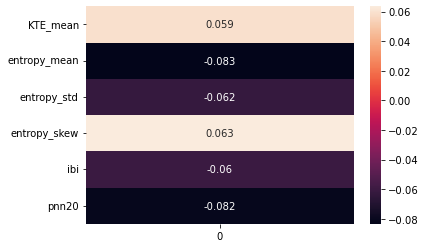

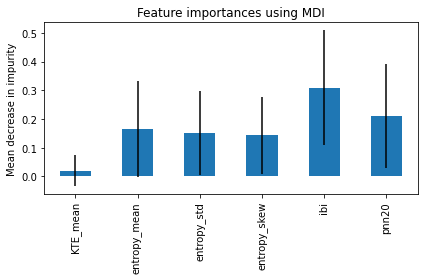

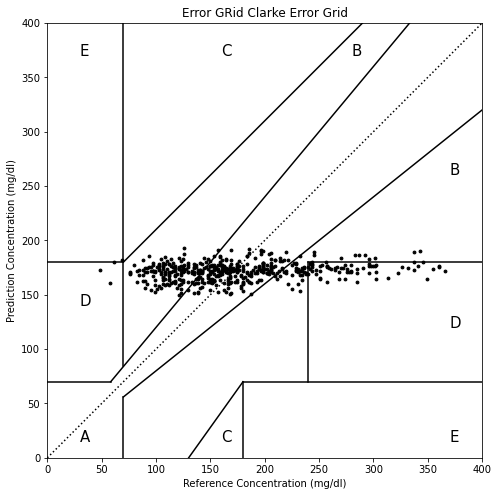

In [160]:
build_asses_model('diabetes.csv', RandomForestRegressor, space4rf, model_nm='rf', evals=20)

## Выборка людей без диабета

NODIABETES.CSV
Target STD: 0.805
Размер обучающей выборки: 591
Размер тестовой выборки: 198
100%|████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.28trial/s, best loss: 0.7764150783291429]
95% доверительный интервал модели для RMSE по кросс валидации: (0.624, 0.929)
R2 test: 0.005, RMSE test: 0.828
Clarke Error Grid: A - 153(77.27%), B - 43(21.72%), C - 0(0.0%), D - 2(1.01%), E - 0(0.0%)



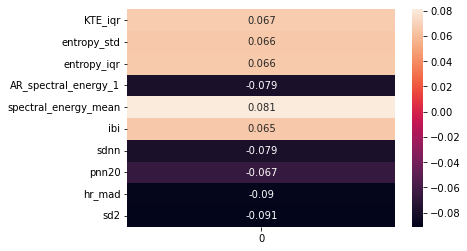

<Figure size 864x576 with 0 Axes>

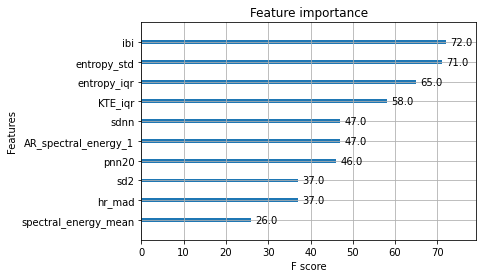

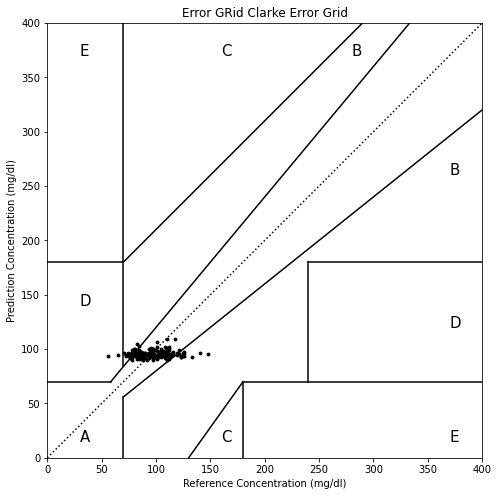

In [185]:
build_asses_model('nodiabetes.csv', XGBRegressor, xgboost_space)

NODIABETES.CSV
Target STD: 0.805
Размер обучающей выборки: 591
Размер тестовой выборки: 198
100%|████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.97s/trial, best loss: 0.7731005792378184]
95% доверительный интервал модели для RMSE по кросс валидации: (0.615, 0.932)
R2 test: -0.030, RMSE test: 0.842
Clarke Error Grid: A - 151(76.26%), B - 45(22.73%), C - 0(0.0%), D - 2(1.01%), E - 0(0.0%)



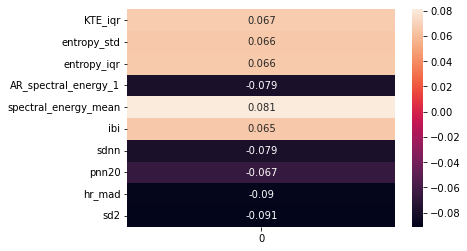

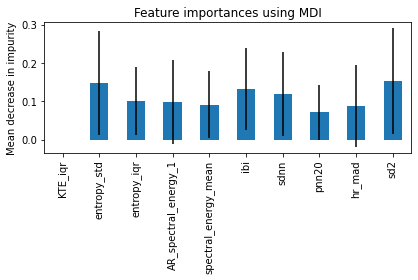

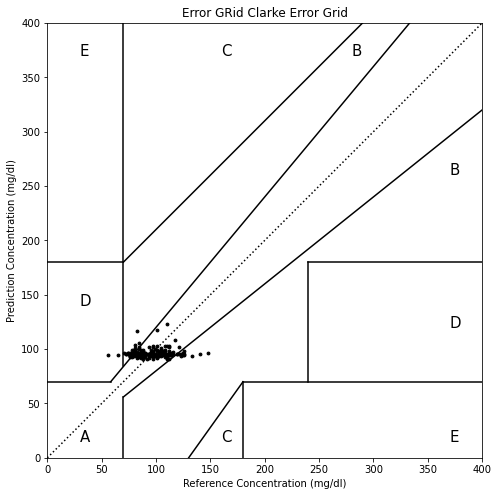

In [184]:
build_asses_model('nodiabetes.csv', RandomForestRegressor, space4rf, model_nm='rf', evals=20)

## Выборка после еды

FOOD.CSV
Target STD: 3.504
Размер обучающей выборки: 1623
Размер тестовой выборки: 542
100%|█████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.76trial/s, best loss: 3.269101526592235]
95% доверительный интервал модели для RMSE по кросс валидации: (2.791, 3.747)
R2 test: 0.147, RMSE test: 3.137
Clarke Error Grid: A - 211(38.93%), B - 289(53.32%), C - 0(0.0%), D - 42(7.75%), E - 0(0.0%)



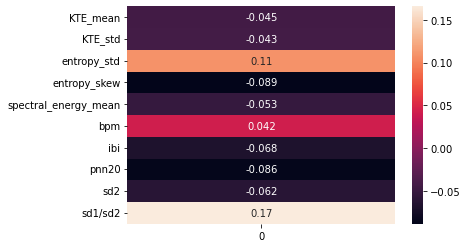

<Figure size 864x576 with 0 Axes>

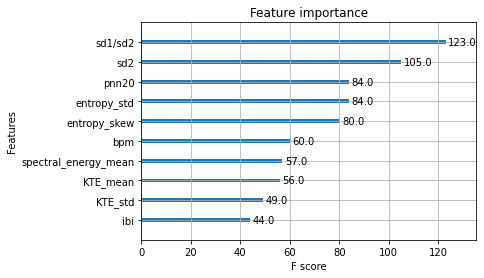

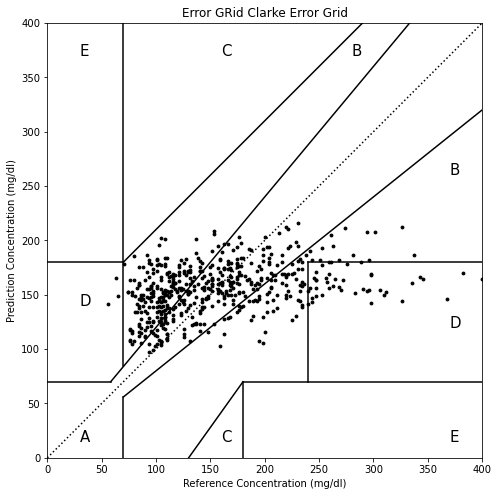

In [186]:
build_asses_model('food.csv', XGBRegressor, xgboost_space)

FOOD.CSV
Target STD: 3.504
Размер обучающей выборки: 1623
Размер тестовой выборки: 542
100%|█████████████████████████████████████████████████| 20/20 [01:10<00:00,  3.53s/trial, best loss: 3.257976106675153]
95% доверительный интервал модели для RMSE по кросс валидации: (2.832, 3.697)
R2 test: 0.133, RMSE test: 3.164
Clarke Error Grid: A - 213(39.3%), B - 283(52.21%), C - 2(0.37%), D - 44(8.12%), E - 0(0.0%)



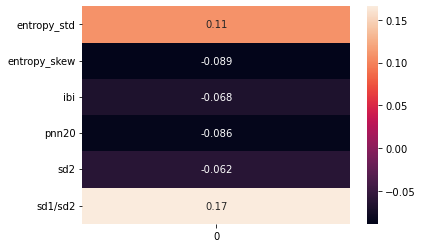

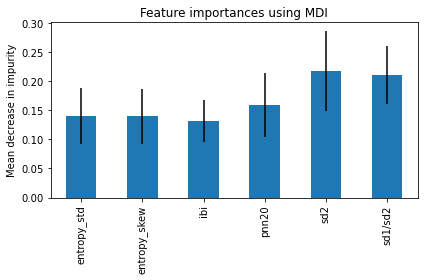

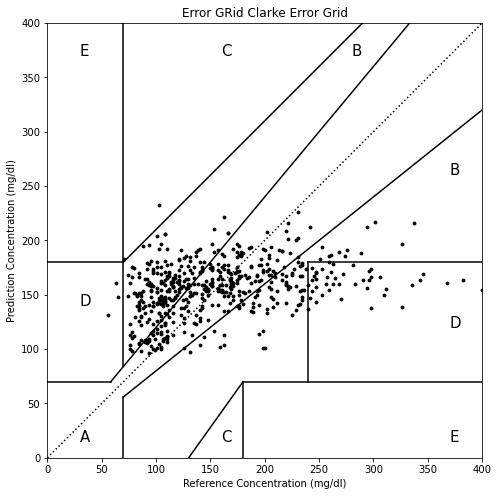

In [164]:
build_asses_model('food.csv', RandomForestRegressor, space4rf, model_nm='rf', evals=20)

## Выборка натощак

FASTING.CSV
Target STD: 2.869
Размер обучающей выборки: 474
Размер тестовой выборки: 158
100%|█████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.00trial/s, best loss: 2.662723138852123]
95% доверительный интервал модели для RMSE по кросс валидации: (1.724, 3.601)
R2 test: 0.148, RMSE test: 2.753
Clarke Error Grid: A - 61(38.61%), B - 85(53.8%), C - 0(0.0%), D - 12(7.59%), E - 0(0.0%)



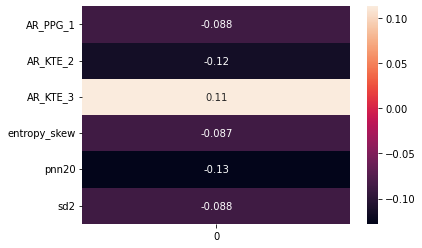

<Figure size 864x576 with 0 Axes>

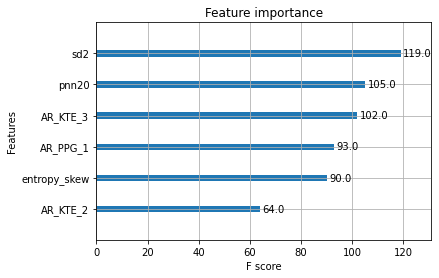

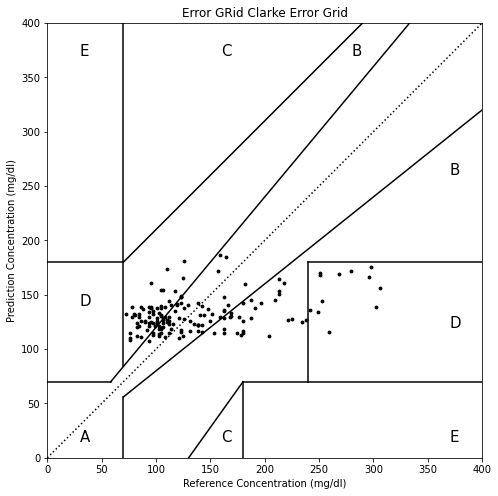

In [165]:
build_asses_model('fasting.csv', XGBRegressor, xgboost_space)

FASTING.CSV
Target STD: 2.869
Размер обучающей выборки: 474
Размер тестовой выборки: 158
100%|████████████████████████████████████████████████| 20/20 [00:48<00:00,  2.42s/trial, best loss: 2.6461916162971626]
95% доверительный интервал модели для RMSE по кросс валидации: (1.799, 3.513)
R2 test: 0.145, RMSE test: 2.757
Clarke Error Grid: A - 63(39.87%), B - 83(52.53%), C - 0(0.0%), D - 12(7.59%), E - 0(0.0%)



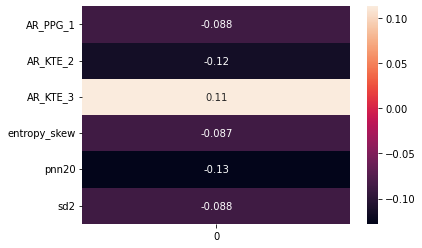

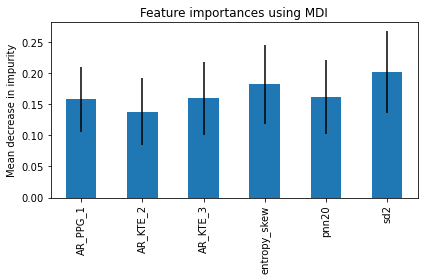

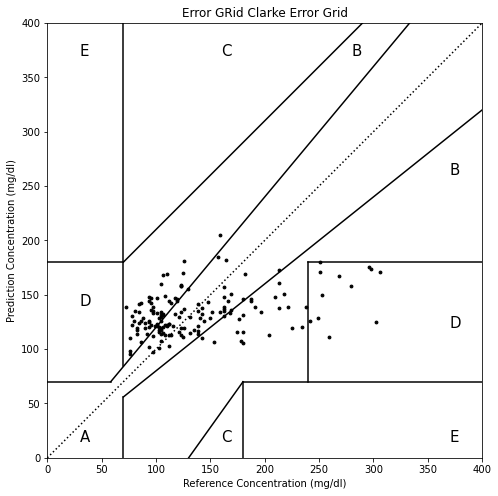

In [166]:
build_asses_model('fasting.csv', RandomForestRegressor, space4rf, model_nm='rf', evals=20)

## Выборка ГКБ

GKB.CSV
Target STD: 3.501
Размер обучающей выборки: 1039
Размер тестовой выборки: 347
100%|████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.27trial/s, best loss: 3.2771324135410964]
95% доверительный интервал модели для RMSE по кросс валидации: (2.920, 3.634)
R2 test: 0.123, RMSE test: 3.239
Clarke Error Grid: A - 136(39.19%), B - 175(50.43%), C - 0(0.0%), D - 35(10.09%), E - 1(0.29%)



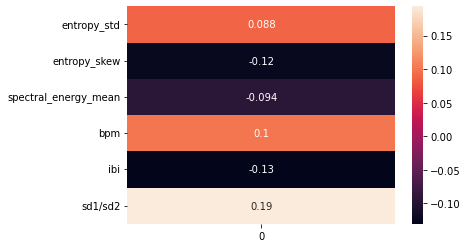

<Figure size 864x576 with 0 Axes>

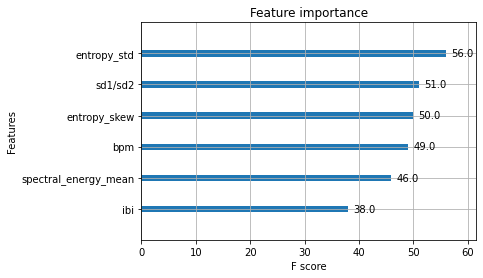

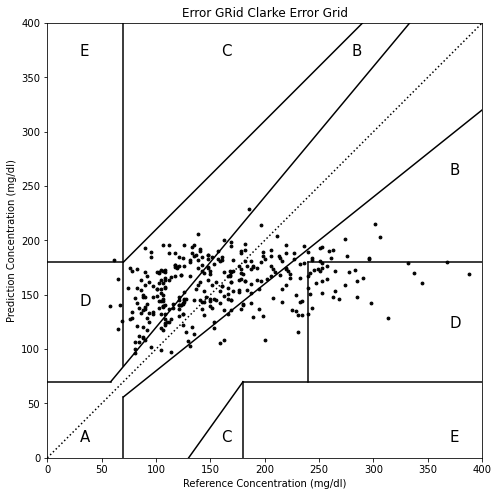

In [167]:
build_asses_model('gkb.csv', XGBRegressor, xgboost_space)

GKB.CSV
Target STD: 3.501
Размер обучающей выборки: 1039
Размер тестовой выборки: 347
100%|█████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.03s/trial, best loss: 3.249858308649089]
95% доверительный интервал модели для RMSE по кросс валидации: (2.982, 3.540)
R2 test: 0.123, RMSE test: 3.239
Clarke Error Grid: A - 129(37.18%), B - 179(51.59%), C - 0(0.0%), D - 39(11.24%), E - 0(0.0%)



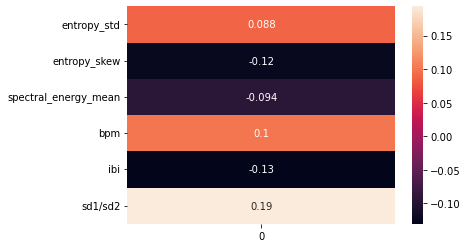

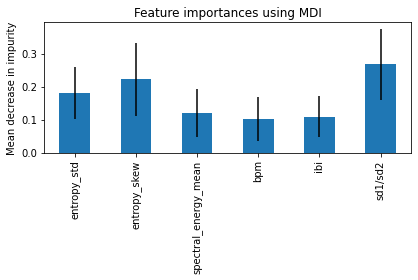

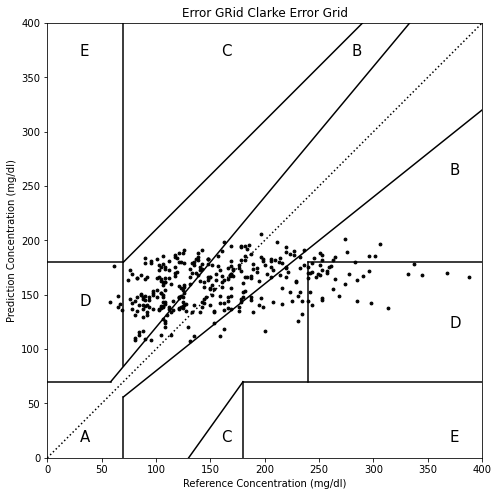

In [168]:
build_asses_model('gkb.csv', RandomForestRegressor, space4rf, model_nm='rf', evals=20)

## Выборка МКНЦ

MKNC.CSV
Target STD: 3.325
Размер обучающей выборки: 924
Размер тестовой выборки: 308
100%|████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14trial/s, best loss: 3.1283968198087577]
95% доверительный интервал модели для RMSE по кросс валидации: (2.177, 4.080)
R2 test: 0.110, RMSE test: 3.085
Clarke Error Grid: A - 121(39.29%), B - 165(53.57%), C - 1(0.32%), D - 21(6.82%), E - 0(0.0%)



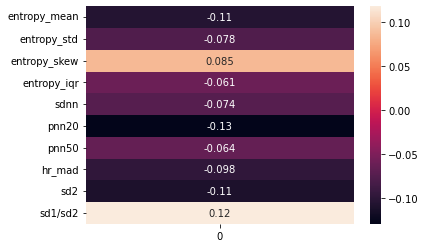

<Figure size 864x576 with 0 Axes>

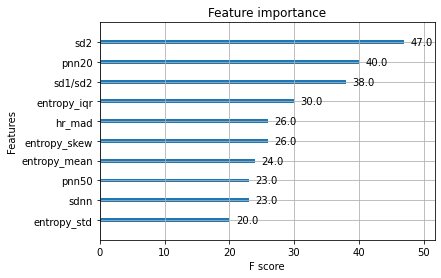

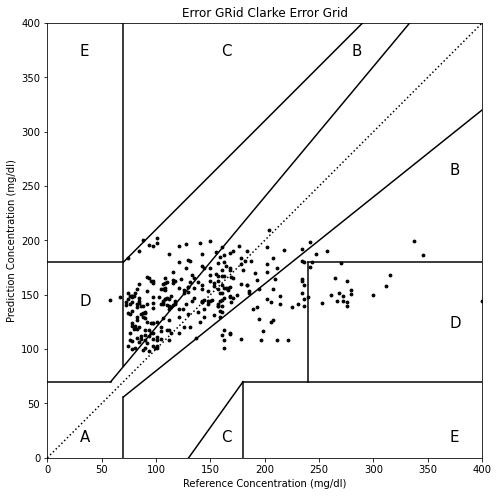

In [182]:
build_asses_model('mknc.csv', XGBRegressor, xgboost_space)

MKNC.CSV
Target STD: 3.325
Размер обучающей выборки: 924
Размер тестовой выборки: 308
100%|█████████████████████████████████████████████████| 20/20 [01:26<00:00,  4.33s/trial, best loss: 3.118779720506354]
95% доверительный интервал модели для RMSE по кросс валидации: (2.185, 4.059)
R2 test: 0.123, RMSE test: 3.062
Clarke Error Grid: A - 119(38.64%), B - 166(53.9%), C - 0(0.0%), D - 23(7.47%), E - 0(0.0%)



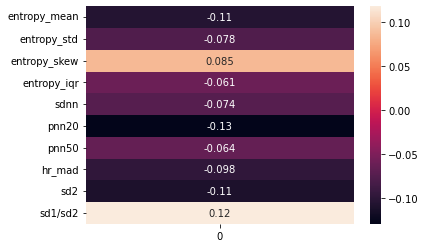

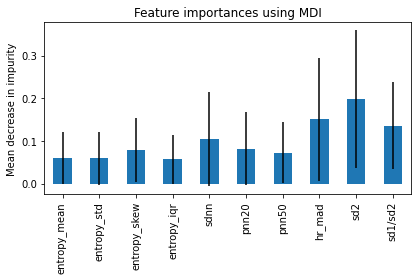

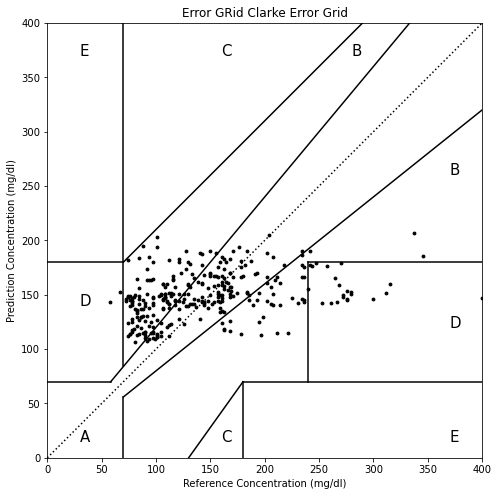

In [183]:
build_asses_model('mknc.csv', RandomForestRegressor, space4rf, model_nm='rf', evals=20)

## Выборка поликлиники

POLY.CSV
Target STD: 0.879
Размер обучающей выборки: 134
Размер тестовой выборки: 45
100%|████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.22trial/s, best loss: 0.8496189156409205]
95% доверительный интервал модели для RMSE по кросс валидации: (0.291, 1.409)
R2 test: 0.160, RMSE test: 0.858
Clarke Error Grid: A - 39(86.67%), B - 6(13.33%), C - 0(0.0%), D - 0(0.0%), E - 0(0.0%)



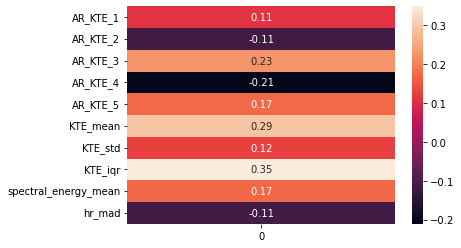

<Figure size 864x576 with 0 Axes>

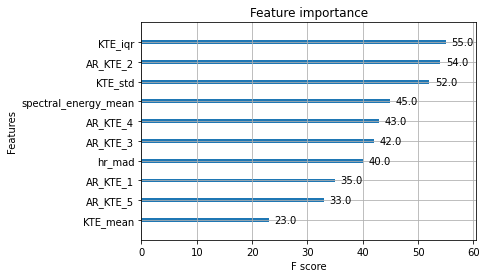

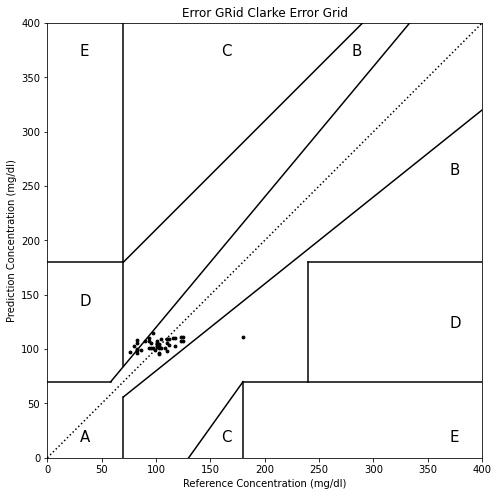

In [180]:
build_asses_model('poly.csv', XGBRegressor, xgboost_space)

POLY.CSV
Target STD: 0.879
Размер обучающей выборки: 134
Размер тестовой выборки: 45
100%|████████████████████████████████████████████████| 20/20 [00:39<00:00,  2.00s/trial, best loss: 0.8390961179782819]
95% доверительный интервал модели для RMSE по кросс валидации: (0.389, 1.294)
R2 test: 0.100, RMSE test: 0.888
Clarke Error Grid: A - 37(82.22%), B - 8(17.78%), C - 0(0.0%), D - 0(0.0%), E - 0(0.0%)



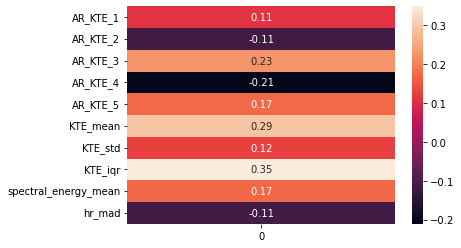

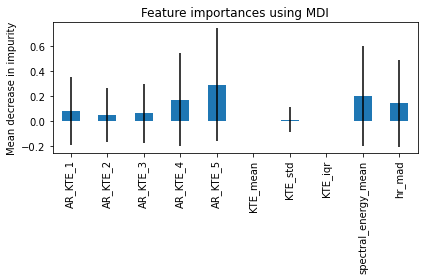

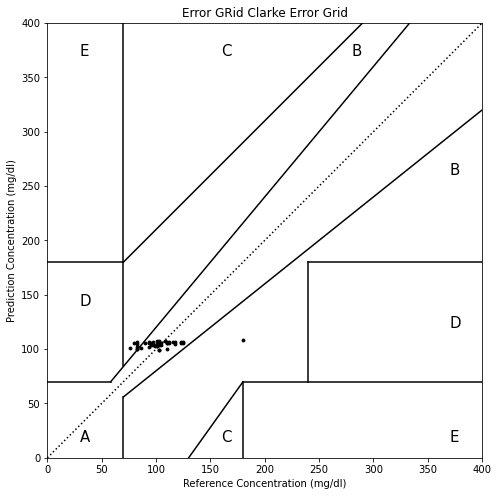

In [181]:
build_asses_model('poly.csv', RandomForestRegressor, space4rf, model_nm='rf', evals=20)

## Выборка до 44

LESS_44.CSV
Target STD: 1.271
Размер обучающей выборки: 387
Размер тестовой выборки: 129
100%|█████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.05trial/s, best loss: 1.222448806842323]
95% доверительный интервал модели для RMSE по кросс валидации: (0.676, 1.769)
R2 test: 0.057, RMSE test: 1.119
Clarke Error Grid: A - 109(84.5%), B - 20(15.5%), C - 0(0.0%), D - 0(0.0%), E - 0(0.0%)



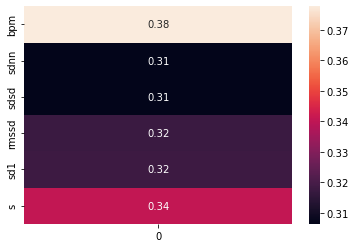

<Figure size 864x576 with 0 Axes>

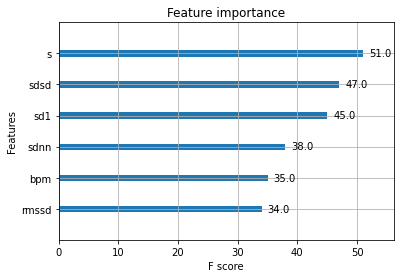

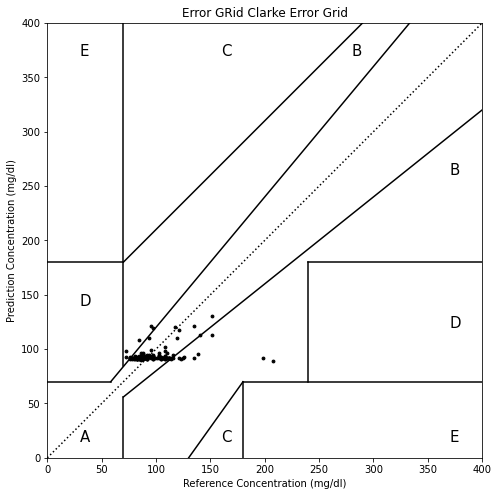

In [173]:
build_asses_model('less_44.csv', XGBRegressor, xgboost_space)

LESS_44.CSV
Target STD: 1.271
Размер обучающей выборки: 387
Размер тестовой выборки: 129
100%|████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.23s/trial, best loss: 1.2170497832841725]
95% доверительный интервал модели для RMSE по кросс валидации: (0.706, 1.751)
R2 test: 0.089, RMSE test: 1.100
Clarke Error Grid: A - 105(81.4%), B - 24(18.6%), C - 0(0.0%), D - 0(0.0%), E - 0(0.0%)



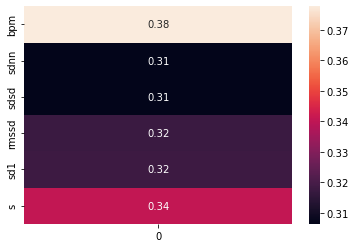

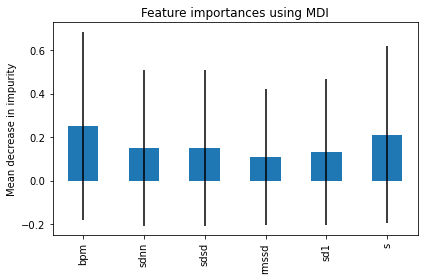

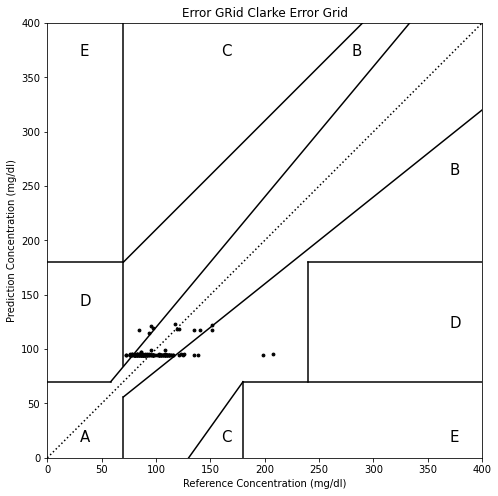

In [174]:
build_asses_model('less_44.csv', RandomForestRegressor, space4rf, model_nm='rf', evals=20)

## Выборка от 45 до 64

FROM_45_TO_64.CSV
Target STD: 3.324
Размер обучающей выборки: 1047
Размер тестовой выборки: 350
100%|████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.08trial/s, best loss: 3.0611709023378433]
95% доверительный интервал модели для RMSE по кросс валидации: (2.278, 3.845)
R2 test: 0.063, RMSE test: 3.297
Clarke Error Grid: A - 147(42.0%), B - 170(48.57%), C - 3(0.86%), D - 30(8.57%), E - 0(0.0%)



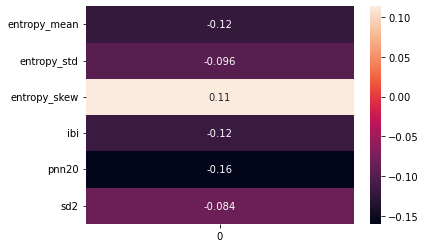

<Figure size 864x576 with 0 Axes>

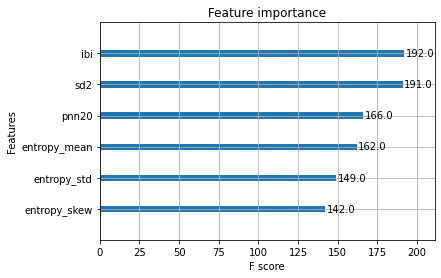

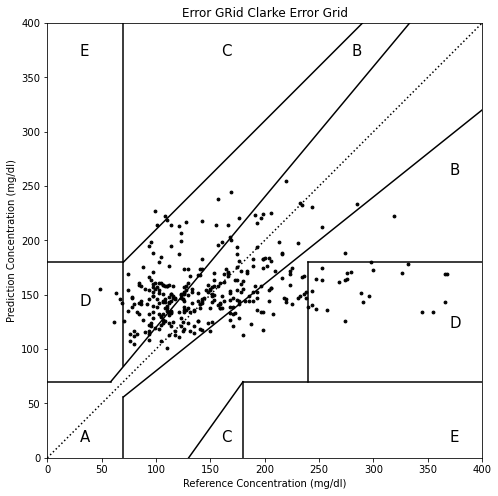

In [175]:
build_asses_model('from_45_to_64.csv', XGBRegressor, xgboost_space)

FROM_45_TO_64.CSV
Target STD: 3.324
Размер обучающей выборки: 1047
Размер тестовой выборки: 350
100%|████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.33s/trial, best loss: 3.0487821525721204]
95% доверительный интервал модели для RMSE по кросс валидации: (2.393, 3.738)
R2 test: 0.058, RMSE test: 3.306
Clarke Error Grid: A - 146(41.71%), B - 170(48.57%), C - 2(0.57%), D - 32(9.14%), E - 0(0.0%)



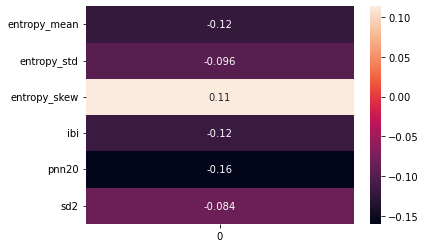

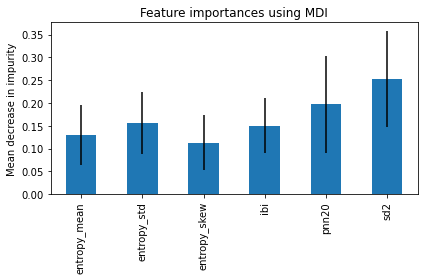

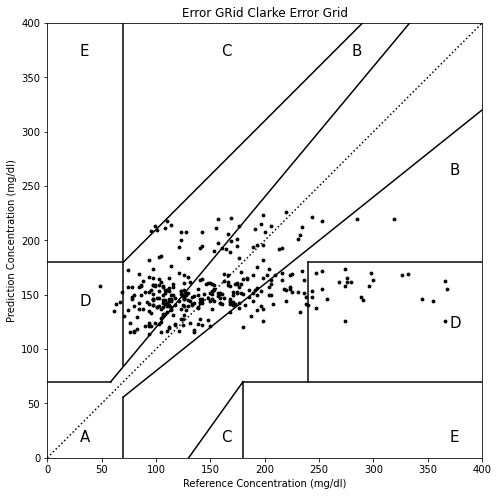

In [176]:
build_asses_model('from_45_to_64.csv', RandomForestRegressor, space4rf, model_nm='rf', evals=20)

## Выборка больше 64

MORE_64.CSV
Target STD: 3.354
Размер обучающей выборки: 663
Размер тестовой выборки: 221
100%|████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.80trial/s, best loss: 3.3722916299036583]
95% доверительный интервал модели для RMSE по кросс валидации: (2.910, 3.835)
R2 test: 0.072, RMSE test: 3.033
Clarke Error Grid: A - 113(51.13%), B - 94(42.53%), C - 0(0.0%), D - 14(6.33%), E - 0(0.0%)



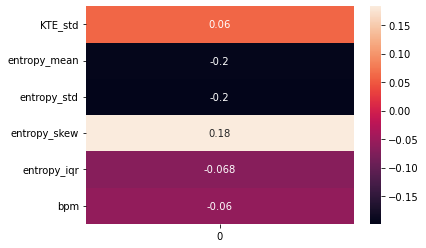

<Figure size 864x576 with 0 Axes>

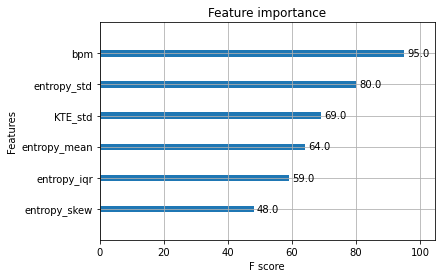

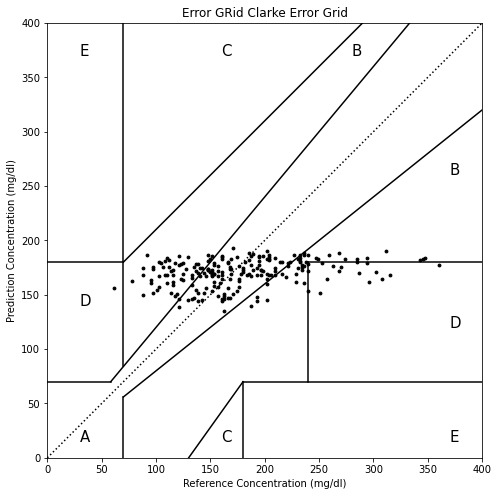

In [177]:
build_asses_model('more_64.csv', XGBRegressor, xgboost_space)

MORE_64.CSV
Target STD: 3.354
Размер обучающей выборки: 663
Размер тестовой выборки: 221
100%|█████████████████████████████████████████████████| 20/20 [00:51<00:00,  2.57s/trial, best loss: 3.363034706502332]
95% доверительный интервал модели для RMSE по кросс валидации: (2.864, 3.860)
R2 test: 0.063, RMSE test: 3.048
Clarke Error Grid: A - 107(48.42%), B - 102(46.15%), C - 0(0.0%), D - 12(5.43%), E - 0(0.0%)



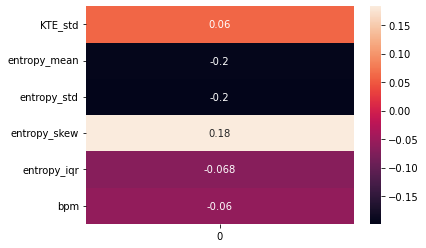

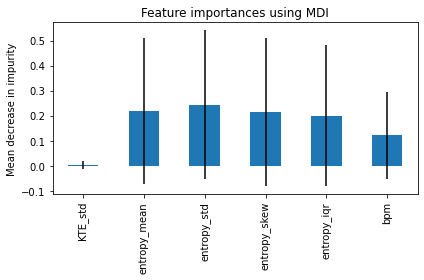

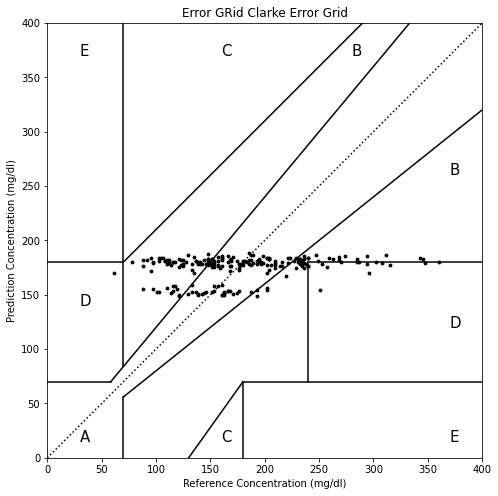

In [178]:
build_asses_model('more_64.csv', RandomForestRegressor, space4rf, model_nm='rf', evals=20)